In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
from matplotlib.ticker import FuncFormatter
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.calibration import calibration_curve, CalibrationDisplay
from data.shots_data_retriever import ShotsDataRetriever
from tqdm import tqdm

In [6]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

In [7]:
print(df.groupby('is_goal').size())
df

is_goal
0    276763
1     29006
dtype: int64


,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,...,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed,time_since_powerplay,away_skaters,home_skaters
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,...,61.0,11.0,1.0,17.088007,False,0.000000,17.088007,0,5,5
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,...,54.0,-5.0,5.0,36.715120,False,0.000000,7.343024,0,5,5
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,...,72.0,0.0,18.0,62.008064,False,0.000000,3.444892,0,5,5
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,...,77.0,-2.0,19.0,45.880279,False,0.000000,2.414752,0,5,5
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,...,47.0,34.0,16.0,14.317821,False,0.000000,0.894864,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68485,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,...,72.0,-21.0,21.0,5.385165,False,0.000000,0.256436,0,5,5
68486,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,...,95.0,-17.0,16.0,58.189346,False,0.000000,3.636834,0,5,5
68487,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,...,76.0,38.0,2.0,28.160256,True,27.501452,14.080128,0,5,5
68488,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,...,60.0,40.0,32.0,51.478151,False,0.000000,1.608692,0,6,5


### XGBClassifier v0:
- Trained on `angle_to_goal` and `distance`
- No hyperparameter tuning

In [8]:
X0 = df[['angle_to_goal', 'distance']]
y = df['is_goal']

X_train_0, X_val_0, y_train, y_val = train_test_split(X0, y, test_size=0.3, random_state=42)


In [16]:
model = XGBClassifier()
model.fit(X_train_0, y_train)
y_pred = model.predict(X_val_0)
y_pred_prob = model.predict_proba(X_val_0)[:, 1]
results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

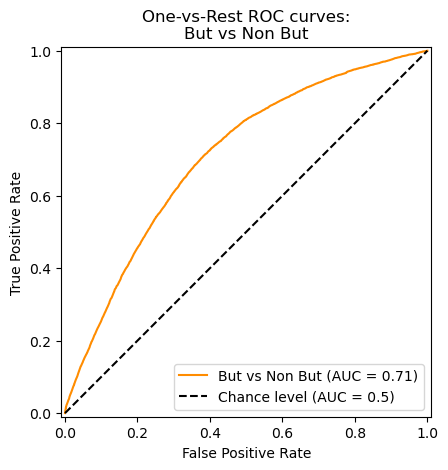

In [10]:
display = RocCurveDisplay.from_predictions(
    results_v0['is_goal'],
    results_v0['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBut vs Non But",
)

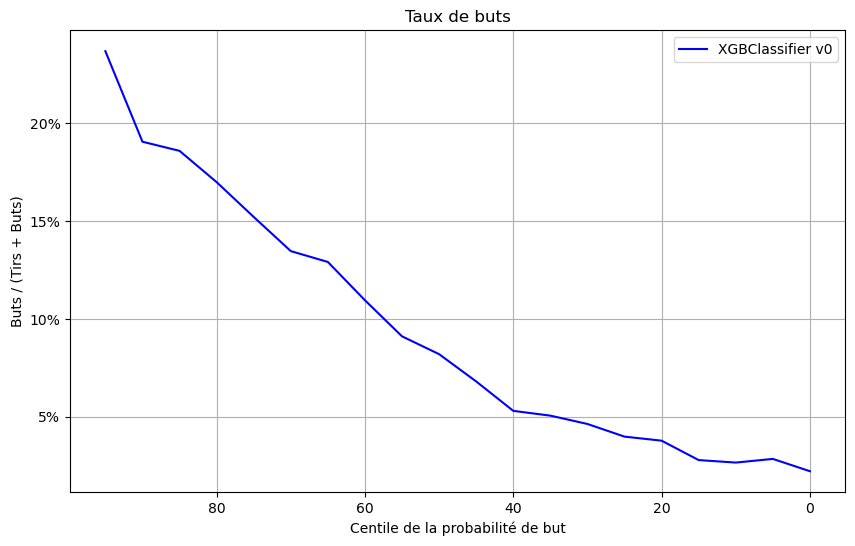

In [14]:
gr_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

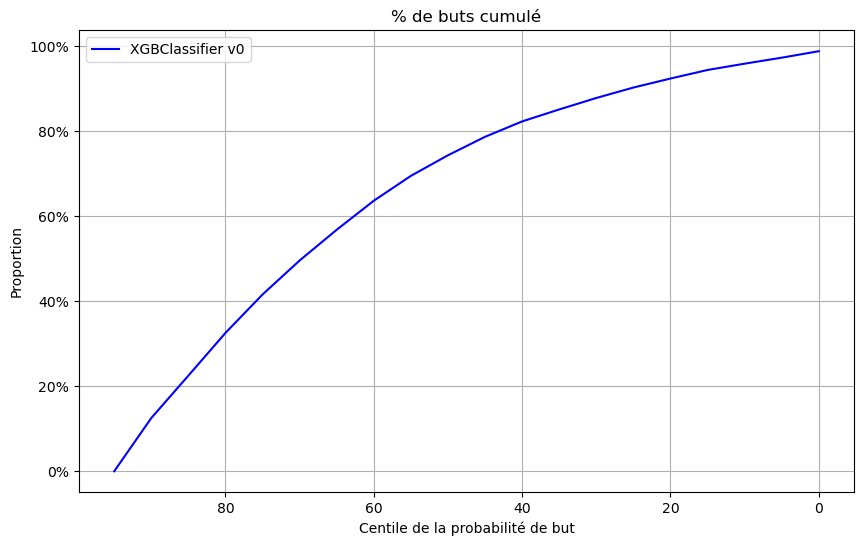

In [17]:
cg_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

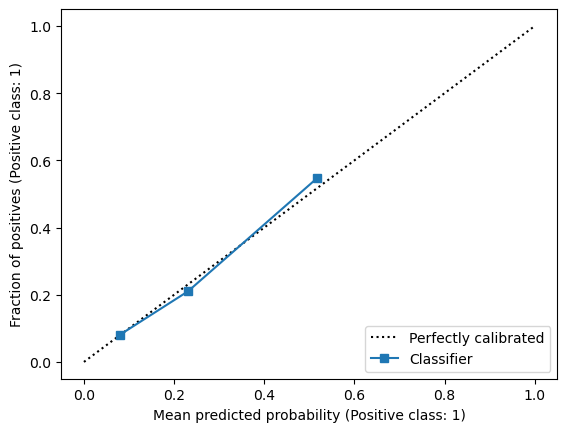

In [18]:
disp = CalibrationDisplay.from_predictions(y_val, results_v0['goal_proba'])
plt.show()

### XGBClassifier v1:
- Trained on all features
- Hyperparameters optimized

In [ ]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X1 = df1.drop(columns=['is_goal', 'game_id', 'play_num'])
y = df1['is_goal']

X_train_1, X_val_1, y_train, y_val = train_test_split(X1, y, test_size=0.3, random_state=42)

#### Scoring metric

There is a notable class imbalance in the dataset - 276763 class 0 data points for 29006 class 1 data points. Further - we are not interested in the classifier's ability to correctly label a shot as a goal or not. Instead, we are more focused on creating a classifier able to predict a realistic probability of goal. Given these requirements, I will choose **log-loss** as my scoring metric.

#### Hyperparameter optimization method
I do not have much experience optimizing XGBoost models and so do not have an intuition for which hyperparameter values to explore. Thus, I will **Bayesian Optimization** as it is capable of intelligently exploring different hyperparameter values without requiring them to be set ahead of time.

In [20]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBClassifier(**params, eval_metric='logloss')
    
    score = cross_val_score(model, X_train_1, y_train, scoring='neg_log_loss', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2024-11-18 17:49:50,855] A new study created in memory with name: no-name-6b14d020-768f-43a7-9f45-62b7c5ed6510
[I 2024-11-18 17:50:11,567] Trial 0 finished with value: -0.3093289341977435 and parameters: {'n_estimators': 344, 'max_depth': 9, 'learning_rate': 0.27996500352796944, 'colsample_bytree': 0.6129278893028571, 'subsample': 0.6390104760534314, 'min_child_weight': 7}. Best is trial 0 with value: -0.3093289341977435.
[I 2024-11-18 17:50:25,334] Trial 1 finished with value: -0.2696750616947198 and parameters: {'n_estimators': 323, 'max_depth': 7, 'learning_rate': 0.17910644565887868, 'colsample_bytree': 0.6915834355891184, 'subsample': 0.9426963840586908, 'min_child_weight': 9}. Best is trial 1 with value: -0.2696750616947198.
[I 2024-11-18 17:50:40,216] Trial 2 finished with value: -0.2683650845295175 and parameters: {'n_estimators': 464, 'max_depth': 4, 'learning_rate': 0.2803600892943779, 'colsample_bytree': 0.5807609460057124, 'subsample': 0.7414796342606134, 'min_child_weig

Best parameters: {'n_estimators': 334, 'max_depth': 7, 'learning_rate': 0.02894018798171535, 'colsample_bytree': 0.6324384216689498, 'subsample': 0.6168215132690374, 'min_child_weight': 6}


In [ ]:
best_params = {
    'n_estimators': 334, 
    'max_depth': 7, 
    'learning_rate': 0.02894018798171535, 
    'colsample_bytree': 0.6324384216689498, 
    'subsample': 0.6168215132690374, 
    'min_child_weight': 6
    }
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train_1, y_train)
y_pred = best_xgb_model.predict(X_val_1)
y_pred_prob = best_xgb_model.predict_proba(X_val_1)[:, 1]

In [21]:
print("Classification report:")
print(classification_report(y_pred, y_val))
results_v1 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     91680
           1       0.00      0.55      0.01        51

    accuracy                           0.91     91731
   macro avg       0.50      0.73      0.48     91731
weighted avg       1.00      0.91      0.95     91731



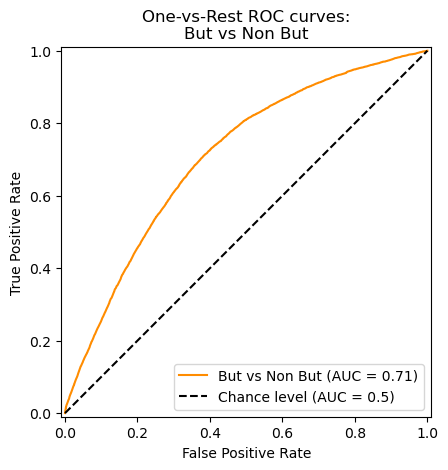

In [22]:
display = RocCurveDisplay.from_predictions(
    results_v1['is_goal'],
    results_v1['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBut vs Non But",
)

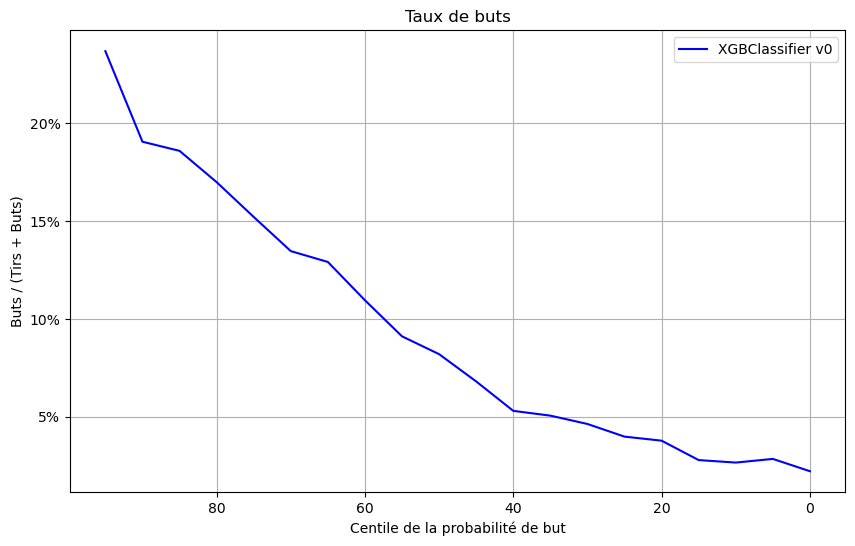

In [ ]:
gr_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

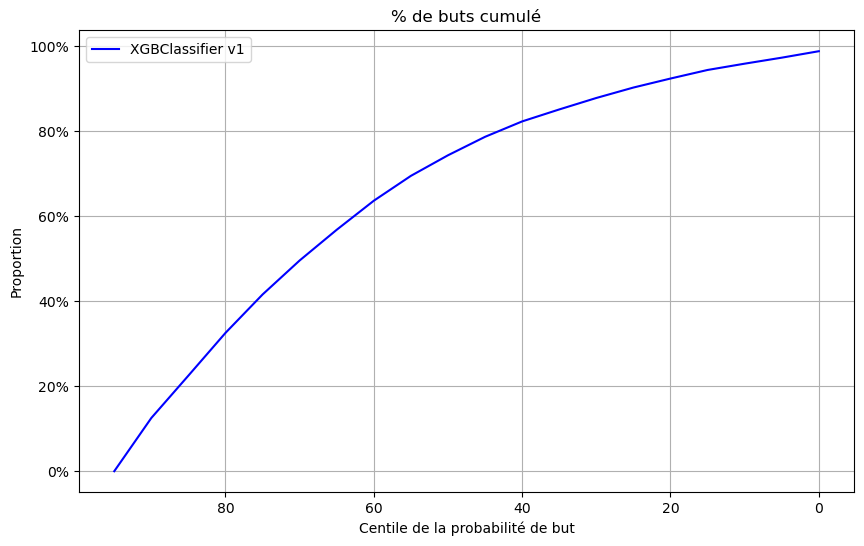

In [25]:
cg_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

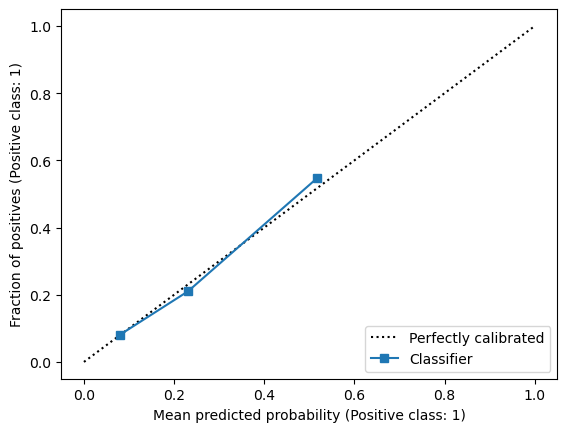

In [26]:
disp = CalibrationDisplay.from_predictions(y_val, results_v1['goal_proba'])
plt.show()

### XGBClassifier v2:
- Trained on select features
- Hyperparameters tuned

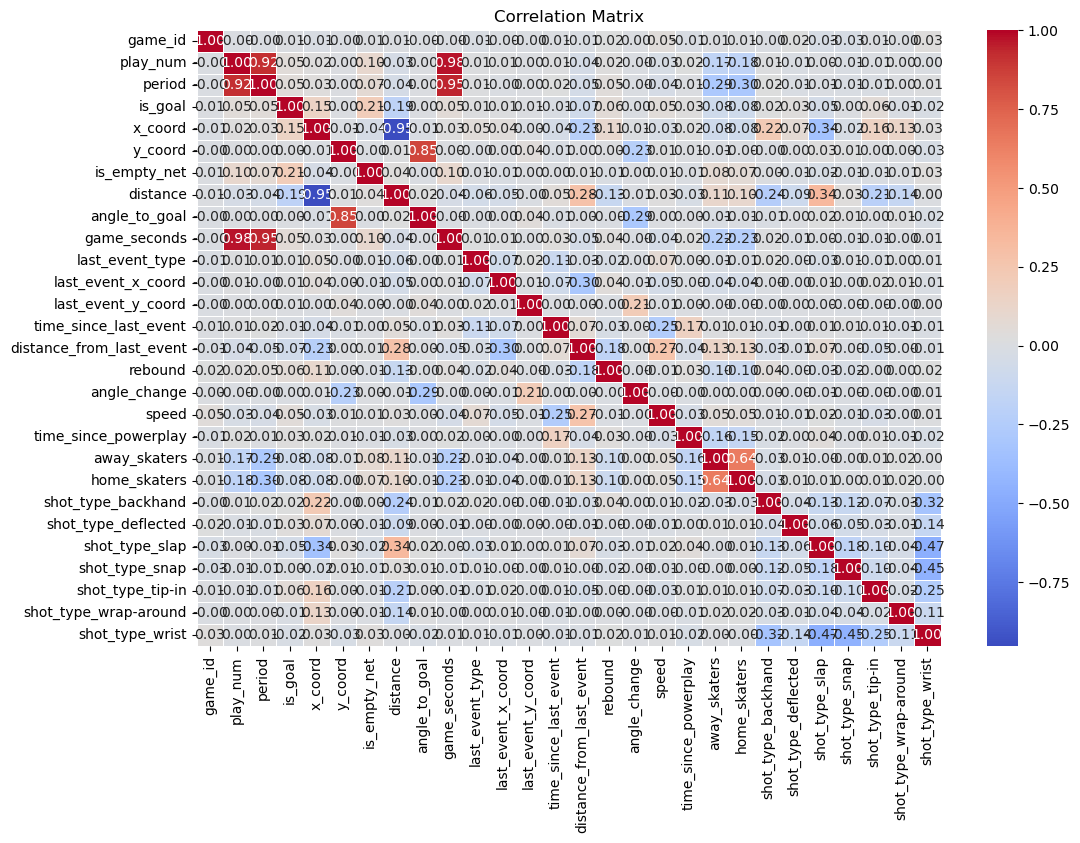

In [29]:
import seaborn as sns

corr_matrix = df1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()